In [273]:
import sys
path = "/usr/local/lib/python3.9/dist-packages/liegroups-1.1.0-py3.9.egg"
if path not in sys.path:
    sys.path.append(path)
    
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import liegroups
import torch.optim
import lietorch

from liegroups.torch import SE3
import torch

In [274]:
class Position3(object):
    def __init__(self, translation, rotation):
        self._rotation = rotation
        self._translation = translation
        
    @classmethod
    def from_vec(cls, vec):
        if len(vec.shape) == 1:
            translation = vec[:3]
            rotation = Rotation.from_euler('xyz', vec[3:], degrees=False)
        return cls(translation, rotation)
    
    def inv(self):
        rotation = self._rotation.inv()
        translation = -rotation.apply(self._translation)
        return Position3(translation, rotation)

    def __mul__(self, other):
        rotation = self._rotation * other._rotation
        translation = self._translation + self._rotation.apply(other._translation)
        return Position3(translation, rotation)
    
    def apply(self, points):
        return self._translation + self._rotation.apply(points)
    
    def as_matrix(self, full=True):
        if len(self._translation.shape) == 1:
            if full:
                result = np.zeros((4, 4))
                result[3, 3] = 1
            else:
                result = np.zeros((3, 4))
            result[:3, :3] = self._rotation.as_matrix()
            result[:3, 3] = self._translation
            return result
    
    def as_qvec(self):
        if len(self._translation.shape) == 1:
            result = np.zeros(7)
            result[:3] = self._translation
            result[3:] = self._rotation.as_quat()
            return result

    def as_se3(self):
        tensor = torch.tensor(self.as_matrix().astype(np.float32))[None]
        return SE3.from_matrix(tensor)
    
    def as_se3_group(self, requires_grad=False):
        tensor = torch.tensor(self.as_qvec().astype(np.float32)[None], requires_grad=requires_grad)
#         tensor.retain_grad(True)
        return lietorch.SE3(tensor)

    def as_se3_parameter(self):
        tensor = torch.tensor(self.as_qvec().astype(np.float32)[None])
        group = lietorch.SE3(tensor)
        return lietorch.LieGroupParameter(group)

# Generate points

In [275]:
np.random.seed(100)
points = np.random.rand(10, 2) * 5
points = np.concatenate([points, np.zeros((10, 1))], axis=1)
points_tensor = torch.tensor(points.astype(np.float32))
points

array([[2.71702471, 1.39184693, 0.        ],
       [2.12258795, 4.22388066, 0.        ],
       [0.02359428, 0.6078456 , 0.        ],
       [3.35374542, 4.12926378, 0.        ],
       [0.68353295, 2.87546665, 0.        ],
       [4.45660977, 1.04601061, 0.        ],
       [0.9266411 , 0.54188445, 0.        ],
       [1.09848746, 4.89311892, 0.        ],
       [4.05841575, 0.85970506, 0.        ],
       [4.08112374, 1.37036874, 0.        ]])

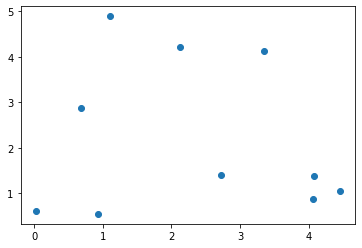

In [276]:
plt.scatter(points[:, 0], points[:, 1])

19.818716157835038

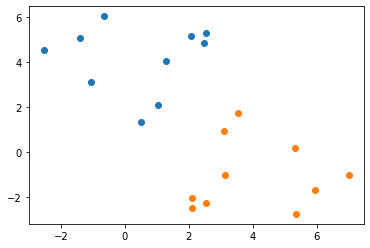

In [337]:
position1 = Position3.from_vec(np.array([1, 1, 0, 0, 0, 1]))
position2 = Position3.from_vec(np.array([3, 2, 0, 0, 0, -2]))

# position2 = Position3.from_vec(np.array([1, 1, 0, 0, 0, -2]))
# position2 = Position3.from_vec(np.array([5, 5, 0, 0, 0, 1]))


# position1 = Position3.from_vec(np.array([10, 1, 0, 0, 0, 1]))
# position1 = Position3.from_vec(np.array([-11, 1, 0, 0, 0, -3]))
# position1 = Position3.from_vec(np.array([-9.19, 1.84, 0, 0, 0, -2.44]))
# position2 = Position3.from_vec(np.array([-10, 2, 0, 0, 0, -2]))

delta_position = position1 * position2.inv()

points1 = position1.apply(points)
points2 = position2.apply(points)
plt.scatter(points1[:, 0], points1[:, 1])
plt.scatter(points2[:, 0], points2[:, 1])
loss = np.mean((points1 - points2) ** 2)
loss

# Liegroups module

In [338]:
log_position1 = position1.as_se3().log()
log_position2 = position2.as_se3().log()
log_position1.requires_grad = True
points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor
points1 = (points_tensor_hom @ SE3.exp(log_position1).as_matrix().T)[:, :3]
points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
loss = torch.mean((points1 - points2) ** 2)
loss.backward()
loss

tensor(19.8187, grad_fn=<MeanBackward0>)

In [339]:
log_position1.grad

tensor([-0.4160,  4.0270,  0.0000,  0.0000,  0.0000,  8.8779])

# Lietorch module

In [340]:
lie_position_parameter1 = position1.as_se3_parameter()
log_position_parameter1 = lie_position_parameter1.log()
log_position_parameter1.retain_grad()
points1 = lietorch.SE3.exp(log_position_parameter1) * points_tensor
points2 = position2.as_se3_group(False).act(points_tensor)
loss = torch.mean((points1 - points2) ** 2)
loss.backward()
loss

tensor(19.8187, grad_fn=<MeanBackward0>)

In [341]:
lie_position_parameter1.grad

tensor([[-2.3942,  3.4777,  0.0000,  0.0000,  0.0000, 11.9056]])

In [342]:
log_position_parameter1.grad

tensor([[-0.4160,  4.0270,  0.0000,  0.0000,  0.0000,  8.8779]])

In [343]:
lietorch.SE3.exp(log_position_parameter1).Jinv(lie_position_parameter1.grad)

tensor([[-1.4963, 13.2237,  0.0000,  0.0000,  0.0000, 11.9056]],
       grad_fn=<ViewBackward0>)

In [344]:
jac = lietorch.SE3.exp(torch.repeat_interleave(log_position_parameter1, 6, dim=0)).Jinv(torch.eye(6)).T
jac

tensor([[ 0.9152,  0.5000,  0.0000,  0.0000,  0.0000, -0.0877],
        [-0.5000,  0.9152,  0.0000,  0.0000,  0.0000,  0.7428],
        [ 0.0000,  0.0000,  1.0000,  0.3276, -0.6724,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.9152,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.5000,  0.9152,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000]],
       grad_fn=<PermuteBackward0>)

In [345]:
(jac @ jac.T @ log_position_parameter1.grad.T).T

tensor([[-1.4963, 13.2237,  0.0000,  0.0000,  0.0000, 11.9056]],
       grad_fn=<PermuteBackward0>)

In [346]:
alpha = 0.001
((lietorch.SE3.exp(alpha * lie_position_parameter1.grad) * lie_position_parameter1.group).log() 
- lie_position_parameter1.log()) / alpha

tensor([[-1.5146, 13.2320,  0.0000,  0.0000,  0.0000, 11.9058]],
       grad_fn=<DivBackward0>)

# Optimization liegroup

In [347]:
# %%timeit
log_position1 = position1.as_se3().log()
log_position2 = position2.as_se3().log()
log_position1.requires_grad = True
points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor
optimizer = torch.optim.Adam([log_position1], lr=6e-2, betas=(0.8, 0.95))
# optimizer = torch.optim.SGD([log_position1], lr=5e-2)
trajectory = [SE3.exp(log_position1).as_matrix().cpu().detach().numpy()]
for i in range(400):
    log_position1.grad = None
    points1 = (points_tensor_hom @ SE3.exp(log_position1).as_matrix().T)[:, :3]
    points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    optimizer.step()
    trajectory.append(SE3.exp(log_position1).as_matrix().cpu().detach().numpy())
trajectory_liegroup = np.array(trajectory)

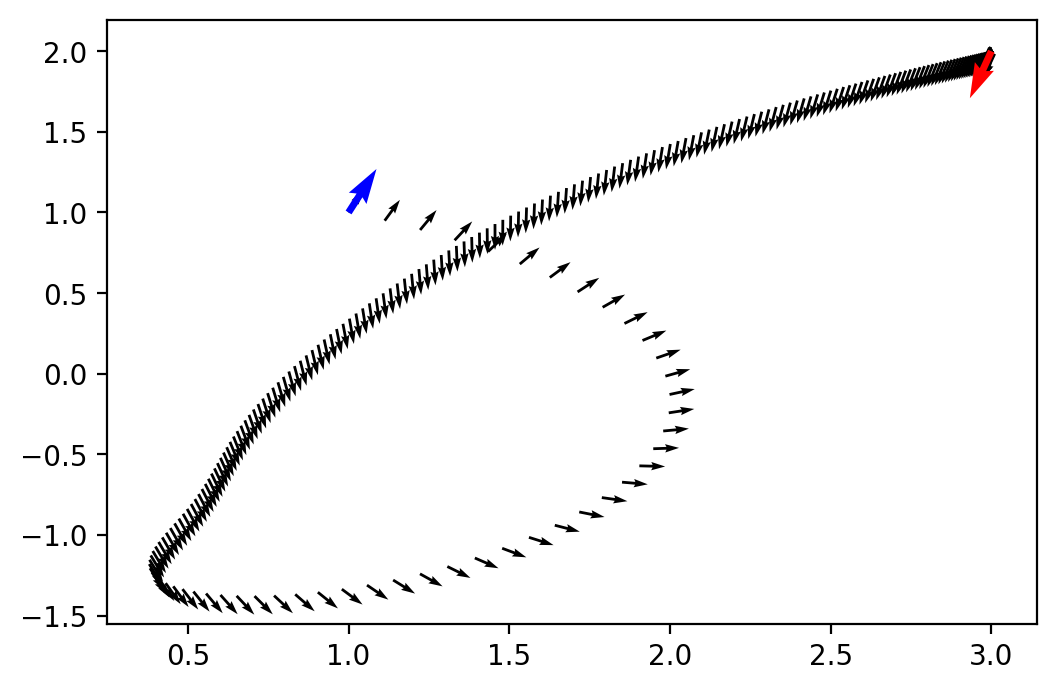

In [348]:
plt.figure(dpi=200)
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0])
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

# Optimization lietorch

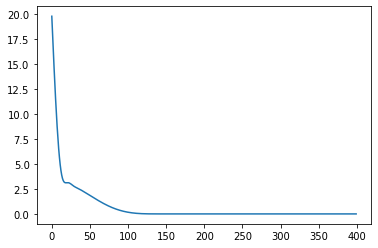

In [349]:
# %%timeit

lie_position_parameter1 = position1.as_se3_parameter()

# optimizer = torch.optim.ASGD([lie_position_parameter1], lr=1.5e-1)
# optimizer = torch.optim.SGD([lie_position_parameter1], lr=2e-2)
optimizer = torch.optim.Adam([lie_position_parameter1], lr=1e-1, betas=(0.8, 0.95))
trajectory = [lie_position_parameter1.group.matrix().cpu().detach().numpy()[0]]
losses = []
for i in range(400):
    lie_position_parameter1.grad = None
    points1 = lie_position_parameter1 * points_tensor
    points2 = position2.as_se3_group(False).act(points_tensor)
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
#     lie_position_parameter1.add_(lie_position_parameter1.grad, -0.2)
    trajectory.append(lie_position_parameter1.group.matrix().cpu().detach().numpy()[0])
lie_torch_trajectory = np.array(trajectory)
plt.plot(losses)

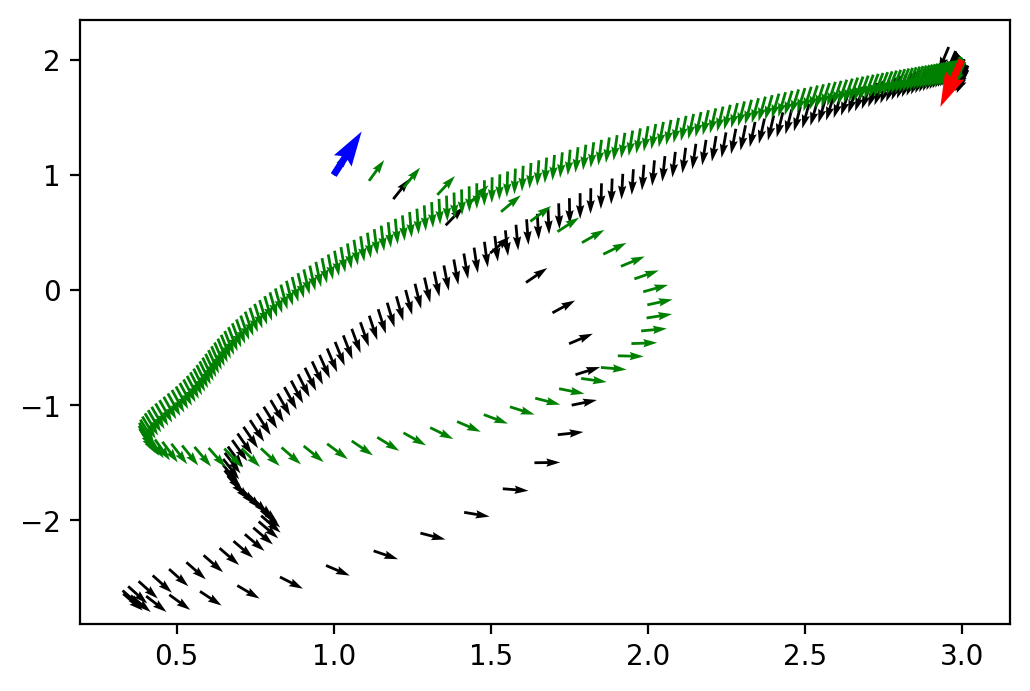

In [350]:
plt.figure(dpi=200)
plt.quiver(lie_torch_trajectory[:, 0, 3], lie_torch_trajectory[:, 1, 3], 
           lie_torch_trajectory[:, 0, 0], lie_torch_trajectory[:, 1, 0])
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

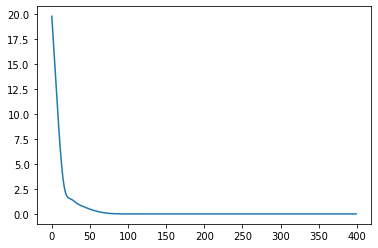

In [351]:
# %%timeit

lie_position_parameter1 = position1.inv().as_se3_parameter()

optimizer = torch.optim.Adam([lie_position_parameter1], lr=1e-1, betas=(0.8, 0.95))
# optimizer = torch.optim.SGD([lie_position_parameter1], lr=5e-2)
trajectory = [lie_position_parameter1.group.inv().matrix().cpu().detach().numpy()[0]]
losses = []
for i in range(400):
    lie_position_parameter1.grad = None
    points1 = lie_position_parameter1.inv() * points_tensor
    points2 = position2.as_se3_group(False).act(points_tensor)
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    trajectory.append(lie_position_parameter1.group.inv().matrix().cpu().detach().numpy()[0])
trajectory = np.array(trajectory)
plt.plot(losses)

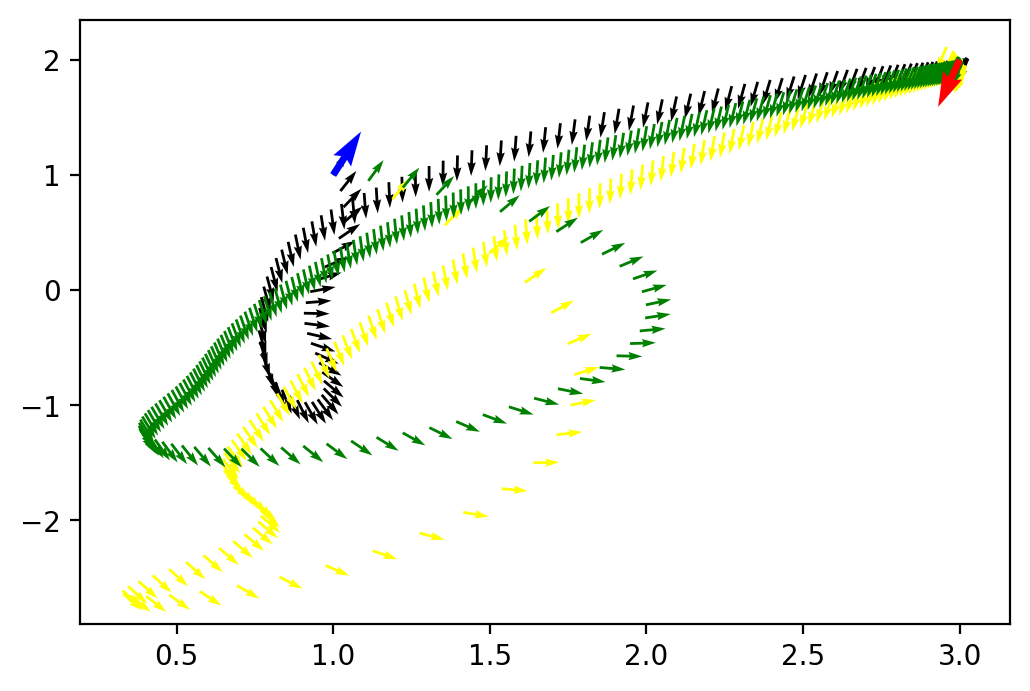

In [352]:
plt.figure(dpi=200)
plt.quiver(trajectory[:, 0, 3], trajectory[:, 1, 3], 
           trajectory[:, 0, 0], trajectory[:, 1, 0])
plt.quiver(lie_torch_trajectory[:, 0, 3], lie_torch_trajectory[:, 1, 3], 
           lie_torch_trajectory[:, 0, 0], lie_torch_trajectory[:, 1, 0], color="yellow")
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

# Parametrize translation and rotation

In [353]:
def matrix_from_translation_and_rotaion(vector):
    result = torch.zeros(4, 4)
    result[3, 3] = 1
    angle = vector[2]
    result[0, 0] = torch.cos(angle)
    result[0, 1] = -torch.sin(angle)
    result[1, 0] = torch.sin(angle)
    result[1, 1] = torch.cos(angle)
    result[2, 2] = 1
    result[0, 3] = vector[0]
    result[1, 3] = vector[1]
    return result

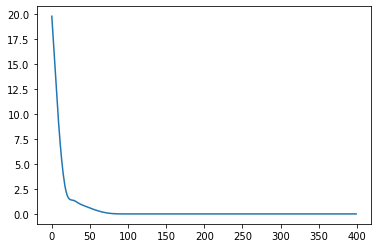

In [354]:
# %%timeit
log_position1 = position1.as_se3().log()
log_position2 = position2.as_se3().log()
parameter = torch.zeros(3, requires_grad=True)
with torch.no_grad():
    parameter[0] = SE3.exp(log_position1).as_matrix()[0, 3]
    parameter[1] = SE3.exp(log_position1).as_matrix()[1, 3]
    parameter[2] = log_position1[5]

points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor
points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
optimizer = torch.optim.Adam([parameter], lr=1e-1, betas=(0.8, 0.95))
# optimizer = torch.optim.SGD([parameter], lr=5e-2)
trajectory = [matrix_from_translation_and_rotaion(parameter).cpu().detach().numpy()]
losses = []
for i in range(400):
    parameter.grad = None
#     parameter[2] = 1
    points1 = (points_tensor_hom @ matrix_from_translation_and_rotaion(parameter).T)[:, :3]
    points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
#     log_position1.data.add_(-0.1 * log_position1.grad)
    optimizer.step()
    trajectory.append(matrix_from_translation_and_rotaion(parameter).cpu().detach().numpy())
trajectory = np.array(trajectory)
plt.plot(losses)

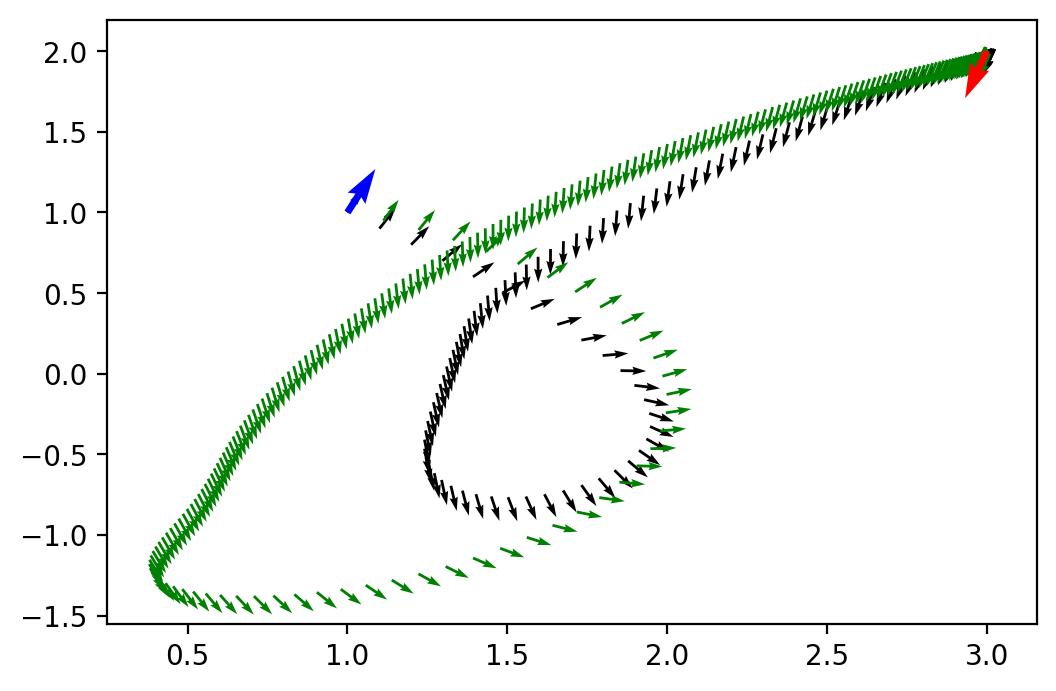

In [355]:
plt.figure(dpi=200)
plt.quiver(trajectory[:, 0, 3], trajectory[:, 1, 3], trajectory[:, 0, 0], trajectory[:, 1, 0])
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

# Optimization gauss newtona lietorch

In [356]:
def calculate_inv_hessian(position_parameter):
    repeated_position = torch.repeat_interleave(lie_position_parameter1.group.data, points_tensor.shape[0] * 3, dim=0)
    repeated_position = lietorch.LieGroupParameter(lietorch.SE3(repeated_position))
    repeated_position.grad = None
    jacobian_loss = torch.sum((repeated_position[:points_tensor.shape[0]] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 0]) +\
    torch.sum((repeated_position[points_tensor.shape[0]:-points_tensor.shape[0]] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 1]) +\
    torch.sum((repeated_position[-points_tensor.shape[0]:] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 2])
    jacobian_loss.backward()
    with torch.no_grad():
        hessian = repeated_position.grad.T @ repeated_position.grad
        inv_hessian = torch.linalg.inv(hessian + 1e-5 * torch.eye(6))
    return inv_hessian

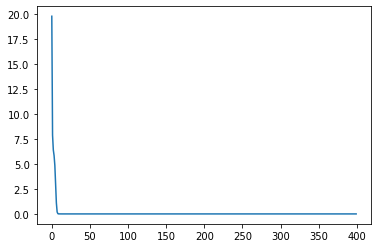

In [357]:
# %%timeit

lie_position_parameter1 = position1.as_se3_parameter()

# optimizer = torch.optim.ASGD([lie_position_parameter1], lr=10)
optimizer = torch.optim.SGD([lie_position_parameter1], lr=10)
# optimizer = torch.optim.Adam([lie_position_parameter1], lr=1e-2, betas=(0.9, 0.95))
trajectory = [lie_position_parameter1.group.matrix().cpu().detach().numpy()[0]]
losses = []
for i in range(400):
    lie_position_parameter1.grad = None
    points1 = lie_position_parameter1 * points_tensor
    points2 = position2.as_se3_group(False).act(points_tensor)
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
    inv_hessian = calculate_inv_hessian(lie_position_parameter1)
    lie_position_parameter1.grad = (inv_hessian @ lie_position_parameter1.grad.T).T
    optimizer.step()
#     lie_position_parameter1.add_(lie_position_parameter1.grad, -0.2)
    trajectory.append(lie_position_parameter1.group.matrix().cpu().detach().numpy()[0])
trajectory = np.array(trajectory)
plt.plot(losses)

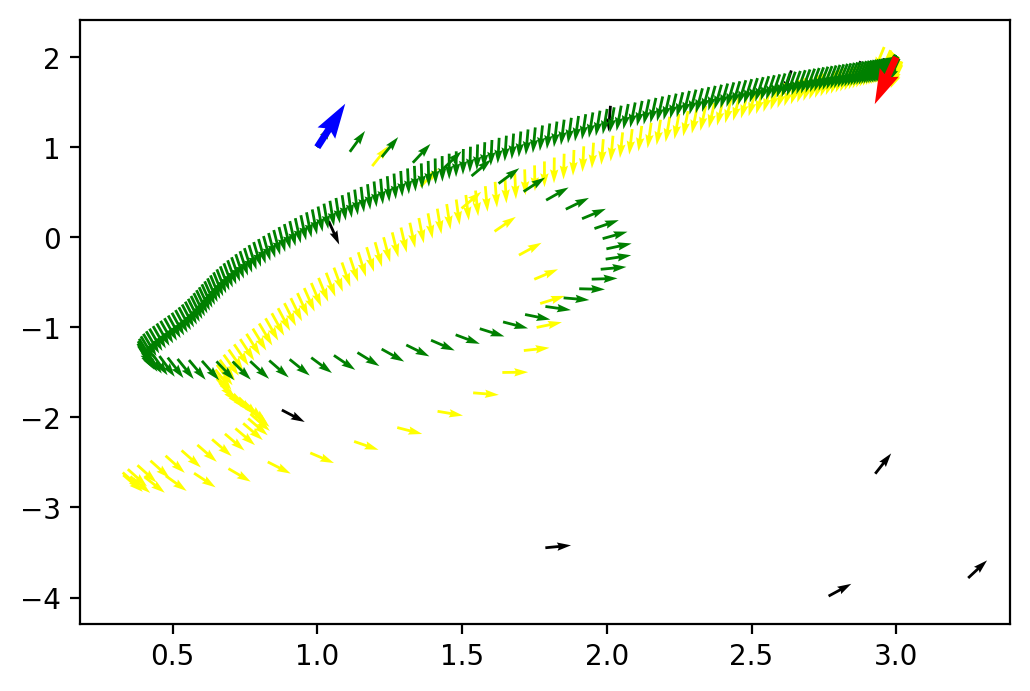

In [358]:
plt.figure(dpi=200)
plt.quiver(trajectory[:, 0, 3], trajectory[:, 1, 3], 
           trajectory[:, 0, 0], trajectory[:, 1, 0])
plt.quiver(lie_torch_trajectory[:, 0, 3], lie_torch_trajectory[:, 1, 3], 
           lie_torch_trajectory[:, 0, 0], lie_torch_trajectory[:, 1, 0], color="yellow")
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

In [359]:
def calculate_inv_hessian_inv(position_parameter):
    repeated_position = torch.repeat_interleave(lie_position_parameter1.group.data, points_tensor.shape[0] * 3, dim=0)
    repeated_position = lietorch.LieGroupParameter(lietorch.SE3(repeated_position))
    repeated_position.grad = None
    inv_repeated_position = repeated_position.inv()
    jacobian_loss = torch.sum((inv_repeated_position[:points_tensor.shape[0]] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 0]) +\
    torch.sum((inv_repeated_position[points_tensor.shape[0]:-points_tensor.shape[0]] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 1]) +\
    torch.sum((inv_repeated_position[-points_tensor.shape[0]:] * points_tensor - 
                              position2.as_se3_group(False).act(points_tensor))[:, 2])
    jacobian_loss.backward()
    with torch.no_grad():
        hessian = repeated_position.grad.T @ repeated_position.grad
        inv_hessian = torch.linalg.inv(hessian + 1e-5 * torch.eye(6))
    return inv_hessian

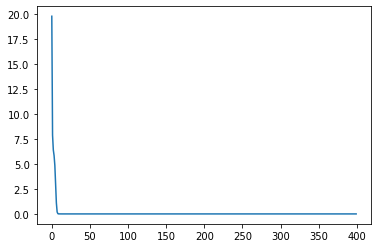

In [360]:
# %%timeit

lie_position_parameter1 = position1.inv().as_se3_parameter()

# optimizer = torch.optim.ASGD([lie_position_parameter1], lr=1)
optimizer = torch.optim.SGD([lie_position_parameter1], lr=10)
# optimizer = torch.optim.Adam([lie_position_parameter1], lr=1e-1, betas=(0.9, 0.95))
trajectory = [lie_position_parameter1.group.inv().matrix().cpu().detach().numpy()[0]]
losses = []
for i in range(400):
    lie_position_parameter1.grad = None
    points1 = lie_position_parameter1.inv() * points_tensor
    points2 = position2.as_se3_group(False).act(points_tensor)
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
    inv_hessian = calculate_inv_hessian_inv(lie_position_parameter1)
    lie_position_parameter1.grad = (inv_hessian @ lie_position_parameter1.grad.T).T
    optimizer.step()
#     lie_position_parameter1.add_(lie_position_parameter1.grad, -0.2)
    trajectory.append(lie_position_parameter1.group.inv().matrix().cpu().detach().numpy()[0])
trajectory = np.array(trajectory)
plt.plot(losses)

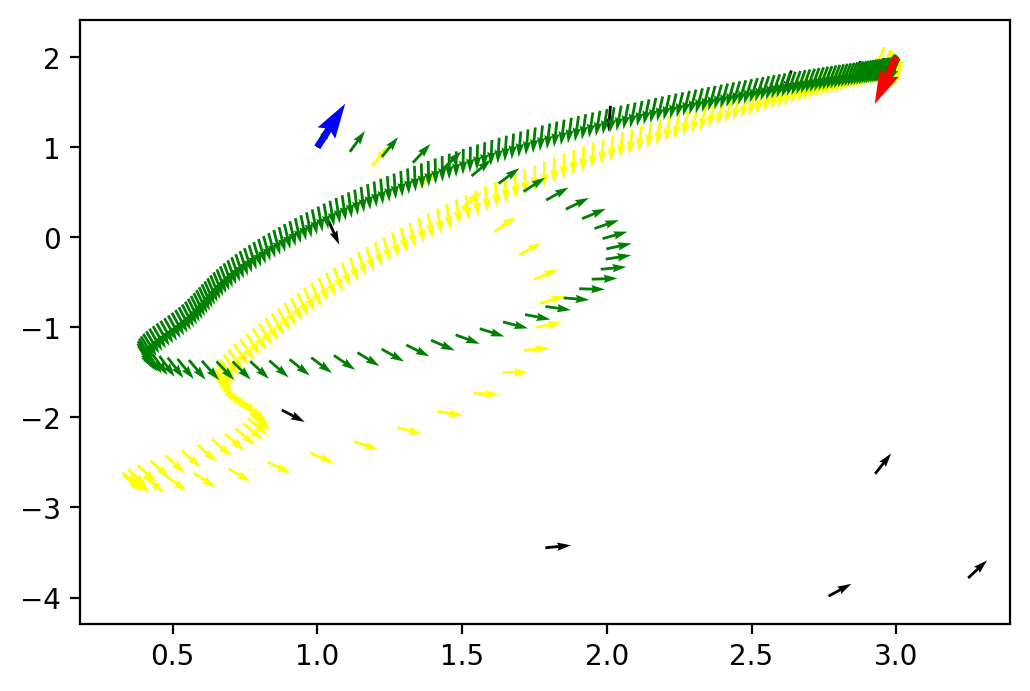

In [361]:
plt.figure(dpi=200)
plt.quiver(trajectory[:, 0, 3], trajectory[:, 1, 3], 
           trajectory[:, 0, 0], trajectory[:, 1, 0])
plt.quiver(lie_torch_trajectory[:, 0, 3], lie_torch_trajectory[:, 1, 3], 
           lie_torch_trajectory[:, 0, 0], lie_torch_trajectory[:, 1, 0], color="yellow")
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

In [394]:
points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor

def points_delta(log_position):
    return torch.bmm(SE3.exp(log_position).as_matrix(), points_tensor_hom[:, :, None])[:, :3, 0] -\
        position2.as_se3_group(False).act(points_tensor)
    
def calculate_inv_hessian_log(log_position):
    points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
    points_tensor_hom[:, :3] = points_tensor
    with torch.no_grad():
        repeated_log_position = torch.repeat_interleave(log_position[None], points_tensor.shape[0] * 3, dim=0)
    repeated_log_position.requires_grad = True
    
    repeated_log_position.grad = None
    n = points_tensor.shape[0]
    jacobian_loss = points_delta(repeated_log_position[:n])[:, 0] +\
                    points_delta(repeated_log_position[n:-n])[:, 1] +\
                    points_delta(repeated_log_position[-n:])[:, 2]
    torch.sum(jacobian_loss).backward()
    with torch.no_grad():
        hessian = repeated_position.grad.T @ repeated_position.grad
        inv_hessian = torch.linalg.inv(hessian + 1e-5 * torch.eye(6))
    return inv_hessian

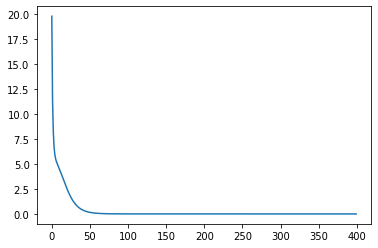

In [407]:
# %%timeit
log_position1 = position1.as_se3().log()
log_position2 = position2.as_se3().log()
log_position1.requires_grad = True
points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor
# optimizer = torch.optim.Adam([log_position1], lr=6e-2, betas=(0.8, 0.95))
optimizer = torch.optim.SGD([log_position1], lr=5)
trajectory = [SE3.exp(log_position1).as_matrix().cpu().detach().numpy()]
losses = []
for i in range(400):
    log_position1.grad = None
    points1 = (points_tensor_hom @ SE3.exp(log_position1).as_matrix().T)[:, :3]
    points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
    loss = torch.mean((points1 - points2) ** 2)
    loss.backward()
    losses.append(loss.item())
    log_position1.grad = (calculate_inv_hessian_log(log_position1) @ log_position1.grad.T).T
    optimizer.step()
    trajectory.append(SE3.exp(log_position1).as_matrix().cpu().detach().numpy())
trajectory = np.array(trajectory)
plt.plot(losses)

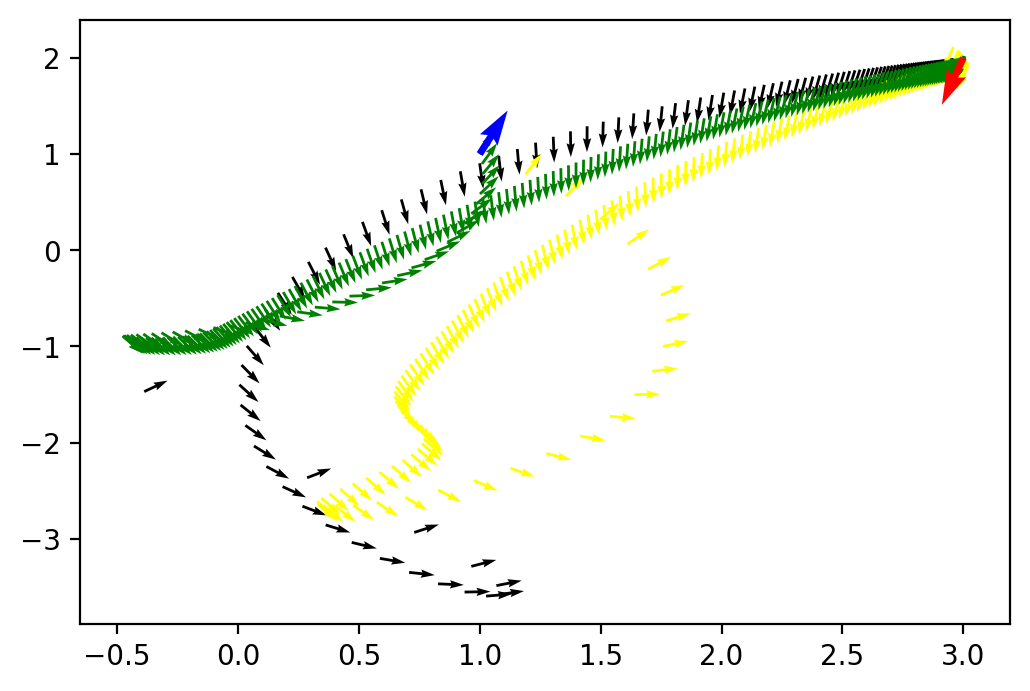

In [408]:
plt.figure(dpi=200)
plt.quiver(trajectory[:, 0, 3], trajectory[:, 1, 3], 
           trajectory[:, 0, 0], trajectory[:, 1, 0])
plt.quiver(lie_torch_trajectory[:, 0, 3], lie_torch_trajectory[:, 1, 3], 
           lie_torch_trajectory[:, 0, 0], lie_torch_trajectory[:, 1, 0], color="yellow")
plt.quiver(trajectory_liegroup[:, 0, 3], trajectory_liegroup[:, 1, 3], 
           trajectory_liegroup[:, 0, 0], trajectory_liegroup[:, 1, 0], color="green")
x = position1.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="blue")
x = position2.as_matrix()
plt.quiver(x[None, 0, 3], x[None, 1, 3], x[None, 0, 0], x[None, 1, 0], color="red")

In [362]:
%%timeit
lie_position_parameter1 = position1.as_se3_parameter()
repeated_position = torch.repeat_interleave(lie_position_parameter1.group.data, points_tensor.shape[0] * 3, dim=0)
repeated_position = lietorch.LieGroupParameter(lietorch.SE3(repeated_position))
repeated_position.grad = None
jacobian_loss = torch.sum((repeated_position[:points_tensor.shape[0]] * points_tensor - 
                          position2.as_se3_group(False).act(points_tensor))[:, 0]) +\
torch.sum((repeated_position[points_tensor.shape[0]:-points_tensor.shape[0]] * points_tensor - 
                          position2.as_se3_group(False).act(points_tensor))[:, 1]) +\
torch.sum((repeated_position[-points_tensor.shape[0]:] * points_tensor - 
                          position2.as_se3_group(False).act(points_tensor))[:, 2])
jacobian_loss.backward()
repeated_position.grad

1.63 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [368]:
group = position1.as_se3_group()
def function(position_parameter):
    parameter = group.retr(position_parameter)
    return (parameter * points_tensor - position2.as_se3_group(False).act(points_tensor)).reshape(-1)

In [370]:
%%timeit
# lie_position_parameter1 = position1.as_se3_parameter()
position_parameter = torch.zeros(1, 6)
position_parameter.requires_grad = True
torch.autograd.functional.jacobian(function, position_parameter, create_graph=True).reshape(30, 6)

3.96 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
